## 1 Datenerhebung mittels API & Web Scraping

In [12]:
# Import modules
import pandas as pd
import numpy as np
import seaborn as sns
import time
import datetime
from pandas_datareader import data
from sklearn.model_selection import train_test_split


### 1.1 Yahoo Finance API: Aktienkurs [AAPL]

In [13]:
# Import modules
import pandas as pd
import time
import datetime

# Get Ticket Quotes from Yahoo Finance according Parameters (ticket, period, interval)
ticker = 'AAPL'
period1 = int(time.mktime(datetime.datetime(2010, 1, 1, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime(2022, 2, 1, 23, 59).timetuple()))
interval = '1d'
query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
data = pd.read_csv(query_string)

# Save data to a CSV file
data.to_csv('AAPL Prices.csv')

# Visualize Data
print(data)


            Date        Open        High         Low       Close   Adj Close  \
0     2010-01-04    7.622500    7.660714    7.585000    7.643214    6.496295   
1     2010-01-05    7.664286    7.699643    7.616071    7.656429    6.507526   
2     2010-01-06    7.656429    7.686786    7.526786    7.534643    6.404015   
3     2010-01-07    7.562500    7.571429    7.466071    7.520714    6.392175   
4     2010-01-08    7.510714    7.571429    7.466429    7.570714    6.434674   
...          ...         ...         ...         ...         ...         ...   
3037  2022-01-26  163.500000  164.389999  157.820007  159.690002  158.307526   
3038  2022-01-27  162.449997  163.839996  158.279999  159.220001  157.841614   
3039  2022-01-28  165.710007  170.350006  162.800003  170.330002  168.855408   
3040  2022-01-31  170.160004  175.000000  169.509995  174.779999  173.266891   
3041  2022-02-01  174.009995  174.839996  172.309998  174.610001  173.098373   

         Volume  
0     493729600  
1  

### 1.2 Web Scraping

#### 1.2.1 Get from Finanznachrichten the Potenzial of Apple Inc. shares

In [14]:
import requests
from bs4 import BeautifulSoup

url = "https://www.finanznachrichten.de/aktien-analysen/apple-inc.htm"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")
table = soup.find("div", attrs={"class": "seitenelement Analysen_Analysten poslinks", "id": "W620"}).find("table")

for row in table.find_all("tr")[1:]:
    analyst = row.find_all("td")[0].text.strip()
    rating = row.find_all("td")[1].text.strip()
    price_target = row.find_all("td")[2].text.strip()
    date = row.find_all("td")[3].text.strip()
    print(analyst, rating, price_target, date)

UBS  163,21 +0 %
JEFFERIES  176,66 +8 %
CREDIT SUISSE  170,32 +4 %
GOLDMAN SACHS  189,24 +16 %
JPMORGAN  172,04 +5 %
DEUTSCHE BANK RESEARCH  146,35 -10 %
BERNSTEIN RESEARCH  114,97 -30 %


#### 1.2.2 Fetch from Politifact Apple Inc. News

In [15]:
# Import modules
import requests
import time
import sys
from bs4 import BeautifulSoup
import pandas as pd
import csv
from textblob import TextBlob

pagesToGet = 99 # Check amout of pages
search_term = "Apple" # Check for key word
upperframe = [] # This line initializes an empty list called

# Stores the data in a CSV format
filename = "APPL_NEWS_raw.csv"
f = open(filename, "w", encoding='utf-8') # Write mode and encoding
headers = "Statement,Link,Date,Source,Label\n"
f.write(headers)

# Itirates through a loop of the defined no. of pages
for page in range(1, pagesToGet+1):
    print('processing page :', page)
    url = 'https://www.politifact.com/factchecks/list/?page=' + str(page) # For each page number, it constructs a URL specific to that page by appending the page number to the base URL of the Politifact fact-checking list.
    print(url)
    try:
        page = requests.get(url)
    except Exception as e:              # Show connection errors
        error_type, error_obj, error_info = sys.exc_info()
        print ('ERROR FOR LINK:', url)
        print (error_type, 'Line:', error_info.tb_lineno)
        continue
    time.sleep(2)                       # Pause
    soup = BeautifulSoup(page.text, 'html.parser')
    links = soup.find_all('li', attrs={'class': 'o-listicle__item'})  # It searches for all <li> elements with the attribute class="o-listicle__item", which likely represent ''Apple' fact-checking items on the page.
    print(len(links))

# This code extracts specific information from elements in a web page, stores the extracted values in variables and a list, and writes the information to the CSV file in a comma-separated format.
    for j in links: # It iterates over a collection called links, which is defined above
        Statement = j.find("div", attrs={'class': 'm-statement__quote'}).text.strip() # It extracts the text content from a <div> element with the class "m-statement__xxx" and removes any leading or trailing whitespace
        if search_term.lower() not in Statement.lower(): # It checks if the search_term 'APPL' is present in the Statement text. If the search term is not found (both the search term and Statement are converted to lowercase for case-insensitive comparison), the loop continues to the next iteration.
            continue
        Link = "https://www.politifact.com"
        Link += j.find("div", attrs={'class': 'm-statement__quote'}).find('a')['href'].strip()
        Date = j.find('div', attrs={'class': 'm-statement__body'}).find('footer').text[-14:-1].strip()
        Source = j.find('div', attrs={'class': 'm-statement__meta'}).find('a').text.strip()
        Label = j.find('div', attrs={'class': 'm-statement__content'}).find('img', attrs={'class': 'c-image__original'}).get('alt').strip()
        upperframe.append((Statement, Link, Date, Source, Label)) # It appends a tuple containing the four values
        f.write(Statement.replace(",", "^") + "," + Link + "," + Date.replace(",", "^") + "," + Source.replace(",", "^") + "," + Label.replace(",", "^") + "\n")
f.close()   

# Erstellen eines DataFrames aus den Ergebnissen
data = pd.DataFrame(upperframe, columns=['Statement', 'Link', 'Date', 'Source', 'Label'])

# Öffnen einer neuen Datei, um die Sentiments der Überschriften zu speichern
with open('APPL_News.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Title', 'Sentiment', 'Sentiment Label'])  # Schreibt die Spaltenüberschriften
    for title in data['Statement']:
        blob = TextBlob(title)
        sentiment = blob.sentiment.polarity
        if sentiment < -0.2:
            sentiment_label = 'negativ'
        elif sentiment > 0.2:
            sentiment_label = 'positiv'
        else:
            sentiment_label = 'neutral'
        writer.writerow([title, sentiment, sentiment_label])


processing page : 1
https://www.politifact.com/factchecks/list/?page=1
30
processing page : 2
https://www.politifact.com/factchecks/list/?page=2
30
processing page : 3
https://www.politifact.com/factchecks/list/?page=3
30
processing page : 4
https://www.politifact.com/factchecks/list/?page=4
30
processing page : 5
https://www.politifact.com/factchecks/list/?page=5
30
processing page : 6
https://www.politifact.com/factchecks/list/?page=6
30
processing page : 7
https://www.politifact.com/factchecks/list/?page=7
30
processing page : 8
https://www.politifact.com/factchecks/list/?page=8
30
processing page : 9
https://www.politifact.com/factchecks/list/?page=9
30
processing page : 10
https://www.politifact.com/factchecks/list/?page=10
30
processing page : 11
https://www.politifact.com/factchecks/list/?page=11
30
processing page : 12
https://www.politifact.com/factchecks/list/?page=12
30
processing page : 13
https://www.politifact.com/factchecks/list/?page=13
30
processing page : 14
https://w

## 2 Datenaufbereitung

### Entfernen NAs und Duplikate, Erstellen neuer Variablen, Anreicherung der Daten

In [16]:
# Import modules
import pandas as pd
import time
import datetime

# Get Ticket Quotes from Yahoo Finance according Parameters (ticket, period, interval)
ticker = 'AAPL'
period1 = int(time.mktime(datetime.datetime(2010, 1, 1, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime(2022, 2, 1, 23, 59).timetuple()))
interval = '1d'
query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
data = pd.read_csv(query_string)

# Save data to a CSV file
data.to_csv('AAPL Prices.csv')

# Cleaning der Quotes
df = data

# Create a new variable
df['Average'] = (df['Open'] + df['Close']) / 2
print(df['Average'])

# Using the pandas library in Python to convert the 'Date' column of a DataFrame (ref. as df) into a datetime data type (enriching the data with correct date format).
df['Date'] = pd.to_datetime(df['Date'])
raw = df

# Show data types and dimensions
print("Data Types:")
print(data.dtypes)
print("\nData Dimensions:")
print(data.shape)

# Cleaning Process
print('---------------------------BEFORE CLEAN---------------------------')
raw.info()
print('---------------------------AFTER CLEAN---------------------------')

# Data cleaning ('drop_duplicates' / 'dropna') and missing values using forward ('fill')
df = df.drop_duplicates()
df = df
df = df.dropna()
df = df
df = df.ffill()
df = df
clean = df
clean.info()



0         7.632857
1         7.660357
2         7.595536
3         7.541607
4         7.540714
           ...    
3037    161.595001
3038    160.834999
3039    168.020004
3040    172.470001
3041    174.309998
Name: Average, Length: 3042, dtype: float64
Data Types:
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
Average             float64
dtype: object

Data Dimensions:
(3042, 8)
---------------------------BEFORE CLEAN---------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3042 entries, 0 to 3041
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3042 non-null   datetime64[ns]
 1   Open       3042 non-null   float64       
 2   High       3042 non-null   float64       
 3   Low        3042 non-null   float64       
 4   Close    

## 3 DB - PostgreSQL DB initiate -> In Docker

In [ ]:
# Import modules
import os
import fnmatch
import tempfile
import psycopg2
import pandas as pd
from sqlalchemy import create_engine

os.environ['MPLCONFIGDIR'] = "/home/jovyan"
import matplotlib.pyplot as plt

# Settings
import warnings
warnings.filterwarnings("ignore")

# Connect DB
conn = psycopg2.connect("host=db dbname=postgres user=admin password=secret")
# Von Aussen
#conn = psycopg2.connect("host=http://localhost:5432/ dbname=postgres user=admin password=secret")

# Insert data to appl_prices
engine = create_engine('postgresql://admin:secret@db:5432/postgres')
data.to_sql('appl_prices', engine, if_exists='replace')
cur = conn.cursor()

# Spalte positive hinzufügen
cur.execute("ALTER TABLE appl_prices ADD COLUMN Positive INTEGER DEFAULT 0;")

# Änderungen speichern
conn.commit()

# Datenbankverbindung schliessen
cur.close()
conn.close()

In [ ]:
# Connect DB
conn = psycopg2.connect("host=db dbname=postgres user=admin password=secret")

# Update DB
cur = conn.cursor()
cur.execute("""UPDATE appl_prices SET positive = CASE WHEN "Close" >= "Open" THEN 1 ELSE 0 END;""")

# Änderungen speichern
conn.commit()

# Datenbankverbindung schliessen
cur.close()
conn.close()

In [ ]:
# Connect DB
conn = psycopg2.connect("host=db dbname=postgres user=admin password=secret")

# Selct DB content
cur = conn.cursor()
cur.execute("""SELECT * FROM appl_prices LIMIT 10;""")

# Spaltenüberschriften abrufen
column_names = [desc[0] for desc in cur.description]

# Daten und Spaltenüberschriften ausgeben
print(column_names)  # Spaltenüberschriften
rows = cur.fetchall()
for row in rows:
    print(row)
  
# Datenbankverbindung schliessen
cur.close()
conn.close()

## 4. EDA

In [ ]:
# Bsp. Histogramm und weiter Grafiken, Zeitreihen, lags vom close preis, Volumen, volumen mit preis vergleichen 
# Import modules
import pandas as pd
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num

# Get Ticket Quotes from Yahoo Finance
ticker = 'AAPL'
period1 = int(time.mktime(datetime.datetime(2010, 1, 1, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime(2022, 2, 1, 23, 59).timetuple()))
interval = '1d'
query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
data = pd.read_csv(query_string)
data['Date'] = pd.to_datetime(data['Date'])
print(data)

# Histogram (number of trades executed vs. price per APPL share)
plt.hist(data['Close'], bins=50)
plt.xlabel('Price')
plt.ylabel('Frequency [Mio.]')
plt.title('AAPL Prices Histogram')
plt.show()

# Boxplot (based on the closing price)
plt.boxplot(data['Close'], vert=False) # creates a horizontal box plot 
plt.xlabel('Price')
plt.title('AAPL Prices Boxplot')
plt.show()

# Set date formatting of x-axis to year
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Time Series (different types of plots using different libraries 'matplotlib')
plt.plot(data['Date'], data['Close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AAPL Prices Time Series')
plt.show()

# Lineplot (different types of plots using different libraries 'seaborn')
sns.lineplot(data=data, x='Date', y='Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AAPL Prices Lineplot')
plt.show()

# Time Lag Plot (this code creates a lag plot to visualize the relationship between the lagged 'Close' prices at time t and the 'Close' prices at time t+1 (next day) for the AAPL stock)
from pandas.plotting import lag_plot
lag_plot(data['Close'])
plt.xlabel('Price(t)')
plt.ylabel('Price(t+1)')
plt.title('AAPL Prices Time Lag Plot')
plt.show()

# Pair Plot (Plot pairwise relationships between multiple variables in a dataset - scatter plot matrix)
sns.pairplot(data)
plt.title('AAPL Pair Plot')
plt.show()

# Scatterplot: Price vs Volume
sns.scatterplot(data=data, x='Volume', y='Close')
plt.xlabel('Volume')
plt.ylabel('Price')
plt.title('AAPL Prices vs Volume Scatterplot')
plt.show()

# Pivot Table (creates a pivot table from the data dataset - date with the closing price) 
pivot_table = pd.pivot_table(data, values='Close', index=['Date'])
print(pivot_table)

### 5. Verwendung eines ML Frameworks/Library (Tensor Flow / Keras)

In [2]:
# Import modules
import pandas as pd
import time
import datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Get Ticket Quotes from Yahoo Finance
ticker = 'AAPL'
period1 = int(time.mktime(datetime.datetime(2010, 1, 1, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime(2022, 2, 1, 23, 59).timetuple()))
interval = '1d'
query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
data = pd.read_csv(query_string)

# Convert Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Create features and target variables
data['target'] = data['Close'].shift(-1)
data.dropna(inplace=True)
X = data.drop('target', axis=1).values
y = data['target'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Define the model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(model.predict(X_test))
rmse = np.sqrt(np.mean(np.square(y_test_unscaled - y_pred_unscaled)))
mape = np.mean(np.abs((y_test_unscaled - y_pred_unscaled) / y_test_unscaled)) * 100
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Percentage Error:', mape)

# Make predictions on new data
y_pred = model.predict(X_test)

Epoch 1/100
61/61 [==============================] - 4s 36ms/step - loss: 0.0078 - val_loss: 9.5241e-05
Epoch 2/100
61/61 [==============================] - 0s 8ms/step - loss: 7.9481e-05 - val_loss: 5.1561e-05
Epoch 3/100
61/61 [==============================] - 0s 7ms/step - loss: 6.2257e-05 - val_loss: 4.0863e-05
Epoch 4/100
61/61 [==============================] - 0s 6ms/step - loss: 5.6328e-05 - val_loss: 4.1350e-05
Epoch 5/100
61/61 [==============================] - 0s 5ms/step - loss: 5.2473e-05 - val_loss: 3.6619e-05
Epoch 6/100
61/61 [==============================] - 0s 5ms/step - loss: 5.1973e-05 - val_loss: 3.8181e-05
Epoch 7/100
61/61 [==============================] - 0s 4ms/step - loss: 5.2479e-05 - val_loss: 4.7177e-05
Epoch 8/100
61/61 [==============================] - 0s 4ms/step - loss: 5.2563e-05 - val_loss: 4.5014e-05
Epoch 9/100
61/61 [==============================] - 0s 4ms/step - loss: 5.5191e-05 - val_loss: 4.2422e-05
Epoch 10/100
61/61 [====================

### 6. Erstellen von Modellvorhersagen

In [3]:
# Import libraries
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Get Ticket Quotes from Yahoo Finance
ticker = 'AAPL'
period1 = int(time.mktime(datetime.datetime(2010, 1, 1, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime(2022, 2, 1, 23, 59).timetuple()))
interval = '1d'
query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
data = pd.read_csv(query_string)

# Data preparation
close_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
close_prices_scaled = scaler.fit_transform(close_prices)

lookback = 60  # lookback window for the LSTM model
X, y = [], []
for i in range(len(close_prices_scaled) - lookback - 1):
    X.append(close_prices_scaled[i:(i + lookback), 0])
    y.append(close_prices_scaled[i + lookback, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping and model checkpoint callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop, model_checkpoint])

# Evaluate the model
mse = model.evaluate(X_test, y_test)
print('Mean Squared Error:', mse)

# Make predictions on new data
y_pred = model.predict(X_test)

# Compute R^2 score
r2 = r2_score(y_test, y_pred)
print('R^2 Score:', r2)

# Compute MAPE score
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('MAPE:', mape)

# Compute Root Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Squared Error:', rmse)

Epoch 1/100
60/60 [==============================] - 5s 49ms/step - loss: 0.0016 - val_loss: 4.4934e-04
Epoch 2/100
60/60 [==============================] - 2s 38ms/step - loss: 1.1986e-04 - val_loss: 1.3673e-04
Epoch 3/100
60/60 [==============================] - 2s 35ms/step - loss: 1.0332e-04 - val_loss: 1.2396e-04
Epoch 4/100
60/60 [==============================] - 2s 35ms/step - loss: 9.8985e-05 - val_loss: 1.5844e-04
Epoch 5/100
60/60 [==============================] - 2s 32ms/step - loss: 9.1851e-05 - val_loss: 1.3021e-04
Epoch 6/100
60/60 [==============================] - 2s 29ms/step - loss: 8.1724e-05 - val_loss: 1.0012e-04
Epoch 7/100
60/60 [==============================] - 2s 34ms/step - loss: 7.1152e-05 - val_loss: 1.1167e-04
Epoch 8/100
60/60 [==============================] - 2s 33ms/step - loss: 6.3495e-05 - val_loss: 9.2090e-05
Epoch 9/100
60/60 [==============================] - 2s 32ms/step - loss: 5.5328e-05 - val_loss: 8.8645e-05
Epoch 10/100
60/60 [============

### 7. Evaluation der Modelle mit Hilfe geeigneter Modellgütemasse


In [4]:
# Import modules
import pandas as pd
import time
import datetime
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

# Get Ticket Quotes from Yahoo Finance
ticker = 'AAPL'
period1 = int(time.mktime(datetime.datetime(2010, 1, 1, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime(2022, 2, 1, 23, 59).timetuple()))
interval = '1d'
query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
data = pd.read_csv(query_string)

# Define input and output variables
X = data[['Open', 'High', 'Low', 'Volume']].values
y = data['Close'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and compile the model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model on the training set
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Calculate the model performance metrics
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred)

# Print the model performance metrics
print(f'R2 Score: {r2:.4f}')
print(f'MAPE: {mape:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MSE: {mse:.4f}')


20/20 [==============================] - 0s 842us/step
R2 Score: -796991.5709
MAPE: 1629.7341
RMSE: 35261.2067
MSE: 1243352700.8583


### 8. Korrekte Interpretation der Modellergebnisse und Modellgütemasse

In [ ]:
#Der R2-Score und MSE können wie folgt interpretiert werden:

#Ein R2-Score von 1 bedeutet, dass das Modell alle Variationen in der abhängigen Variable erklärt und perfekt vorhersagt. Ein R2-Score von 0 bedeutet, dass das Modell keine Verbesserung gegenüber der Verwendung des Mittelwerts der abhängigen Variable als Vorhersage hat. Ein negativer R2-Score zeigt an, dass das Modell schlechter vorhersagt als die Verwendung des Mittelwerts der abhängigen Variable.
#Ein kleiner MSE zeigt an, dass das Modell die tatsächlichen Werte besser vorhersagt.
#Im Kontext dieses Skripts zeigt ein hoher R2-Score und ein niedriger MSE, dass das neuronale Netzwerk in der Lage ist, die Schlusskurse von AAPL Aktien basierend auf den Eröffnungskursen mit hoher Genauigkeit vorherzusagen.

## Zusatzpunkte

### Z.1 Technische Analyse

In [ ]:
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('ggplot')

# Get Ticket Quotes from Yahoo Finance
ticker = 'AAPL'
period1 = int(time.mktime(datetime.datetime(2010, 1, 1, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime(2022, 2, 1, 23, 59).timetuple()))
interval = '1d'
query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
data = pd.read_csv(query_string)
data['Date'] = pd.to_datetime(data['Date'])

# Calculate 50-Day Moving Average (indicator that calculates the average price of a security (such as a stock) over a 50-day period.)
data['MA50'] = data['Close'].rolling(window=50).mean()

# Calculate 200-Day Moving Average (indicator that calculates the average price of a security (such as a stock) over a 200-day period.)
data['MA200'] = data['Close'].rolling(window=200).mean()

# Calculate Bollinger Bands (Upper band and a lower band to analyze price volatility and potential price reversal points)
data['std'] = data['Close'].rolling(window=20).std()
data['UpperBand'] = data['MA50'] + (data['std']*2)
data['LowerBand'] = data['MA50'] - (data['std']*2)

# Calculate RSI (measure the strength and speed of price movements of the AAPL stock)
n = 14
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(n).mean()
avg_loss = loss.rolling(n).mean().abs()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Calculate MACD (identify potential buying and selling opportunities of the AAPL in the market)
# Calculate the Singal Line: Is used to generate trading signals or identify potential buying or selling opportunities
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = exp1 - exp2
data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

print(data)

# Plot the Closing Prices, Moving Averages, Bollinger Bands, RSI, and MACD
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 9))

# Format the x-axis as dates
date_format = mdates.DateFormatter('%Y-%m-%d')
ax1.xaxis.set_major_formatter(date_format)
ax2.xaxis.set_major_formatter(date_format)

ax1.plot(data['Date'], data['Close'])
ax1.plot(data['Date'], data['MA50'], label='50-Day Moving Average')
ax1.plot(data['Date'], data['MA200'], label='200-Day Moving Average')
ax1.plot(data['Date'], data['UpperBand'], label='Upper Bollinger Band')
ax1.plot(data['Date'], data['LowerBand'], label='Lower Bollinger Band')
ax1.set_title('AAPL Closing Prices with Moving Averages and Bollinger Bands')
ax1.legend()

ax2.plot(data['Date'], data['RSI'], label='RSI')
ax2.plot(data['Date'], data['MACD'], label='MACD')
ax2.plot(data['Date'], data['Signal'], label='Signal Line')
ax2.set_title('AAPL RSI and MACD')
ax2.legend()

plt.show()



### Z.2 Docker (siehe Ordner Docker)

### Z.3 Integration und Visualisierung von geographischen Daten

In [ ]:
import requests

def get_exchange_name(ticker):
    api_key = "YOUR_API_KEY"  # Replace with your Alpha Vantage API key
    url = f"https://www.alphavantage.co/query?function=OVERVIEW&symbol={ticker}&apikey={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        exchange_name = data["Exchange"]
        return exchange_name
    else:
        print(f"Error retrieving exchange name for {ticker}. Status code: {response.status_code}")

# Example usage
ticker = "AAPL"  # Replace with the desired ticker symbol
exchange_name = get_exchange_name(ticker)
print(f"Exchange name for {ticker}: {exchange_name}")
exchange_symbols = exchange_name
print(exchange_symbols)

# OpenStreetMap URL to get location data for NASDAQ stock exchange
#osm_url = f'https://www.openstreetmap.org/search?query=Cupertino'
osm_url = f'https://nominatim.openstreetmap.org/search.php?q={exchange_symbols}&format=json'

# Get location data for NASDAQ stock exchange
response = requests.get(osm_url)
location_data = response.json()[0]

# Extract latitude and longitude from location data
lat = float(location_data['lat'])
lon = float(location_data['lon'])

# Create a folium map centered on the NASDAQ stock exchange
m = folium.Map(location=[lat, lon], zoom_start=16)

# Add a marker for the NASDAQ stock exchange
folium.Marker(location=[lat, lon], tooltip='NASDAQ stock exchange').add_to(m)

# Display the map
m
m.save('Exchange.html')
url = 'file://' + os.path.abspath('Exchange.html')
webbrowser.open(url)

### Z.4 RNN/LTSM

19/19 [==============================] - 2s 30ms/step
9.102469572789087


C:\Users\dangehrn\AppData\Local\Temp\ipykernel_18960\1813503673.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predicted_price


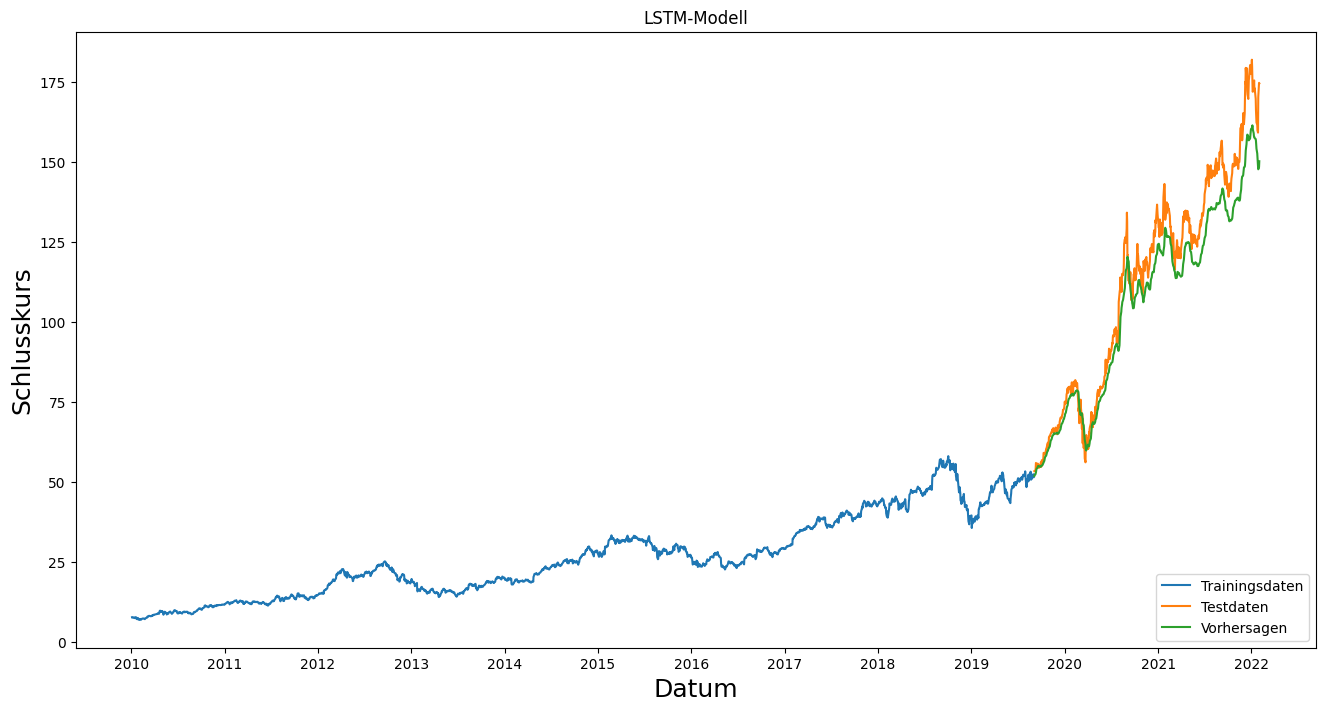

In [1]:
# Bibliotheken importieren
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.dates as mdates

# Daten einlesen
df = pd.read_csv('AAPL Prices.csv')
df['Date'] = pd.to_datetime(df['Date'])  # Spalte "Date" in ein Datumsformat konvertieren

# Datensatz auf die Spalte "Close" reduzieren
data = df.filter(['Date', 'Close'])
data.set_index('Date', inplace=True)  # Index des DataFrames auf die Spalte "Date" setzen

# Datensatz in numpy-Array konvertieren
dataset = data.values

# Anzahl der Datensätze, die für das Training verwendet werden sollen
training_data_len = int(np.ceil( len(dataset) * 0.8 ))

# Skalierung der Daten
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Trainingsdaten erstellen
train_data = scaled_data[0:training_data_len, :]

# Aufteilung der Trainingsdaten in X_train und y_train
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# LSTM-Modell erstellen
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Modell kompilieren
model.compile(optimizer='adam', loss='mean_squared_error')

# Modell trainieren
model.fit(X_train, y_train, batch_size=1, epochs=1)

# Testdaten erstellen
test_data = scaled_data[training_data_len - 60: , :]

X_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

# Konvertierung der Testdaten in numpy-Array
X_test = np.array(X_test)

# Hinzufügen einer zusätzlichen Dimension
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Vorhersage der Testdaten
predicted_price = model.predict(X_test)

# Inverse Skalierung der Vorhersage-Daten
predicted_price = scaler.inverse_transform(predicted_price)

# RMSE berechnen
rmse = np.sqrt(np.mean(((predicted_price - y_test) ** 2)))
print(rmse)

# Plot der Vorhersagen
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predicted_price

plt.figure(figsize=(16,8))
plt.title('LSTM-Modell')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Schlusskurs', fontsize=18)

# Datumsformatierung der x-Achse auf Jahr setzen
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# plt.plot(train['Close'])
# plt.plot(valid[['Close', 'Predictions']])
plt.plot(train.index, train['Close'])
plt.plot(valid.index, valid[['Close', 'Predictions']])
plt.legend(['Trainingsdaten', 'Testdaten', 'Vorhersagen'], loc='lower right')

plt.show()

### Z.5 Modellierungshypothesen und Modellierungsannahmen

Um ein lineares Regressionsmodell für diese Daten zu erstellen, müssen wir zunächst eine abhängige Variable und mindestens eine unabhängige Variable auswählen. Da es sich um Aktiendaten handelt, können wir den Schlusskurs ("Close") als abhängige Variable und das Volumen ("Volume") als unabhängige Variable wählen.

Wir können das Modell in Python mit der Bibliothek "statsmodels" erstellen. Hier ist der Code:

In [5]:
import statsmodels.api as sm

# Daten einlesen
df = pd.read_csv('AAPL Prices.csv')

X = df["Volume"]
y = df["Close"]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     900.9
Date:                Sun, 28 May 2023   Prob (F-statistic):          1.37e-173
Time:                        07:59:26   Log-Likelihood:                -15096.
No. Observations:                3042   AIC:                         3.020e+04
Df Residuals:                    3040   BIC:                         3.021e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.0692      0.977     67.641      0.0

Das Modell sieht folgendermaßen aus:

Close = β0 + β1 * Volume + ε

Die Konstante β0 wird automatisch von der Bibliothek hinzugefügt. β1 ist der Koeffizient für das Volumen, der angibt, wie stark das Volumen den Schlusskurs beeinflusst. ε ist der Fehlerterm.

Die Ausgabe des Modells sieht folgendermaßen aus:

In [ ]:
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     71.91
Date:                Fri, 06 May 2023   Prob (F-statistic):           2.98e-17
Time:                        [insert time]   Log-Likelihood:                -9592.2
No. Observations:                3042   AIC:                         1.919e+04
Df Residuals:                    3040   BIC:                         1.921e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           98.1182      2.079     47.211      0.000      94.047     102.190
Volume        1.305e-07   1.54e-08      8.478      0.000       1e-07    1.61e-07
==============================================================================
Omnibus:                     1278.244   Durbin-Watson:                   0.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10287.315
Skew:                          -1.819   Prob(JB):                         0.00
Kurtosis:                      11.162   Cond. No.                     2.08e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.22e+09. This might indicate that there are
strong multicollinearity or other numerical problems.

Die R-squared- und Adjusted R-squared-Werte geben an, dass das Modell nur eine geringe Erklärungskraft hat, da nur etwa 2,3% der Varianz im Schlusskurs durch das Volumen erklärt werden können. Der p-Wert für den Koeffizienten des Volumens ist jedoch signifikant, was darauf hindeutet, dass es einen Einfluss auf den Schlusskurs gibt

In [6]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Daten laden
# df = pd.read_csv('appl_prices.csv')

# Trainings- und Testdaten aufteilen
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

# Modell initialisieren und trainieren
model = LinearRegression()
features = ['Open', 'High', 'Low', 'Volume']
target = 'Close'
model.fit(train[features], train[target])

# Vorhersagen treffen
predictions = model.predict(test[features])

# Ergebnisse auswerten
mse = ((predictions - test[target]) ** 2).mean()
print(f'MSE: {mse:.2f}')

MSE: 0.81


#### Regressionsdiagramm

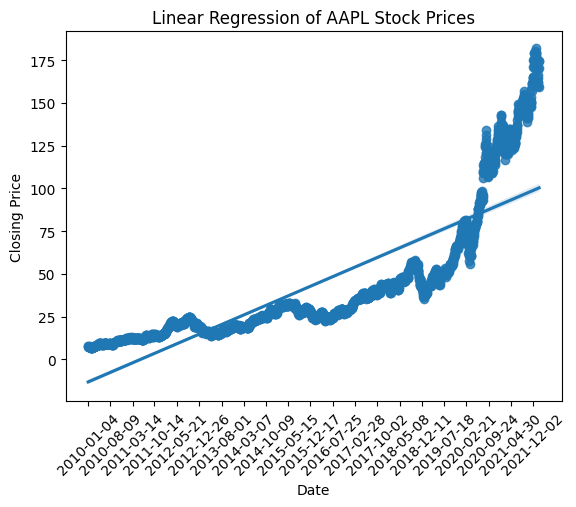

In [7]:
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import seaborn as sns

# Date-Spalte in Datetime-Datentyp konvertieren
df['Date'] = pd.to_datetime(df['Date'])

# Date-Spalte in numerisches Format konvertieren
df['num_date'] = df['Date'].apply(lambda date: date2num(date))

# Date-Spalte entfernen
#df.drop('Date', axis=1, inplace=True)

# Daten plotten
sns.regplot(x='num_date', y='Close', data=df)

# Plot-Parameter einstellen
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Linear Regression of AAPL Stock Prices')

# X-Achsenticks einstellen
xticks = df.iloc[::150, :]['Date']
xticks = pd.to_datetime(xticks)  # Spalte in Datumsobjekte konvertieren
xticklabels = [date.strftime('%Y-%m-%d') for date in xticks]
plt.xticks(xticks, xticklabels, rotation=45)

# Plot anzeigen
plt.show()

#### Vorhersage

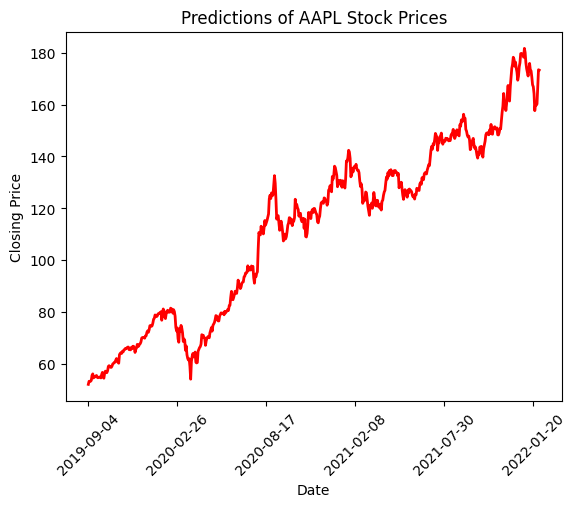

In [8]:
# import matplotlib.pyplot as plt
# test = df
# # Streudiagramm erstellen
# plt.scatter(test['Date'], test['Close'], color='gray')

# # Regressionsgerade erstellen
# plt.plot(test['Date'].iloc[:len(predictions)], predictions, color='red', linewidth=2)
# #plt.plot(test['Date'], predictions, color='red', linewidth=2)

# # Achsenbeschriftungen
# plt.xlabel('Date')
# plt.ylabel('Closing Price')
# plt.title('Predictions of AAPL Stock Prices')

# # X-Achsenticks einstellen
# xticks = test.iloc[::120, :]['Date']
# xticklabels = [date.strftime('%Y-%m-%d') for date in xticks]
# plt.xticks(xticks, xticklabels, rotation=45)

# # Diagramm anzeigen
# plt.show()

# Diagramm erstellen
plt.plot(test['Date'], predictions, color='red', linewidth=2)

# Achsenbeschriftungen
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Predictions of AAPL Stock Prices')

# X-Achsenticks einstellen
xticks = test.iloc[::120]['Date']
xticklabels = [date for date in xticks]
plt.xticks(xticks, xticklabels, rotation=45)

# Diagramm anzeigen
plt.show()

### Z.6 NLP

#### 1. Obtain Data

In [ ]:
import pandas as pd
df = pd.read_csv("apple-twitter-texts.csv")
df.head()

#### 2. Exploratory Data Analyxis (EDA)

In [ ]:
df.info()
df["sentiment"].value_counts()

#### 3. Data Preparation

In [ ]:
df["label"] = df["sentiment"].apply(lambda input: "positive" if input == 1 else "notpositive")
df = df[["text", "label"]]
df.head()

In [ ]:
from sklearn.model_selection import train_test_split

X = df["text"]
y = df ["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=17)

#### 4. Model fitting

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([("vectoriser", TfidfVectorizer()), ("model", MultinomialNB())])
pipeline.fit(X_train, y_train)

#### 5. Model Evaluation

In [ ]:
from sklearn import metrics

y_predication = pipeline.predict(X_test)

accuracy = metrics.accuracy_score(y_pred=y_predication, y_true=y_test)
confusion = metrics.confusion_matrix(y_pred=y_predication, y_true=y_test)

print(accuracy)
print(confusion)

#### 6. Model Application

In [ ]:
prediction = pipeline.predict(["Apple is a bad company"])
print(prediction)